In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import salem

%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
file = '/media/ck/LStorage/wrfout_07_merge.nc'

In [4]:
da = xr.open_dataset(file)

In [5]:
def open_wrf_dataset(file, pole_longitude=0, pole_latitude=0,
                       central_rotated_longitude=0., **kwargs):
   

    # open with xarray
    ds = xr.open_dataset(file, **kwargs)

    srs = ('+ellps=WGS84 +proj=ob_tran +o_proj=latlon '
           '+to_meter=0.0174532925199433 '
           '+o_lon_p={o_lon_p} +o_lat_p={o_lat_p} +lon_0={lon_0} +no_defs')
    params = {
        'o_lon_p': central_rotated_longitude,
        'o_lat_p': pole_latitude,
        'lon_0': 180 + pole_longitude,
    }
    srs = srs.format(**params)

    # add pyproj string everywhere
    ds.attrs['pyproj_srs'] = srs
    for v in ds.data_vars:
        ds[v].attrs['pyproj_srs'] = srs

    return ds

In [6]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [17]:
ds = open_wrf_dataset(file)

In [18]:
da = ds['U'].sel(time = ds.time.dt.hour.isin([12,15,18])).groupby('time.hour').mean('time')

In [28]:
grid = da.salem.grid
grid

<salem.Grid>
  proj: +ellps=WGS84 +lon_0=180 +no_defs+o_lat_p=0 +o_lon_p=0 +o_proj=latlon +proj=ob_tran
  pixel_ref: center
  origin: lower-left
  (nx, ny): (798, 425)
  (dx, dy): (5000.0, 0.04709625244140625)
  (x0, y0): (-1992500.0, 10.218177795410156)

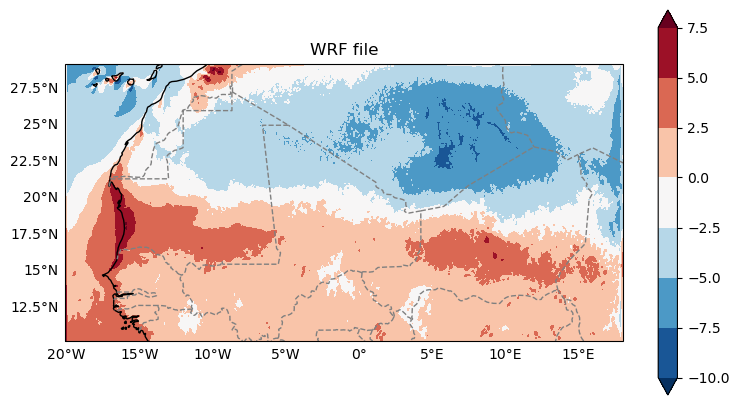

In [33]:
f = plt.figure(figsize=(9,5))
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
draw_map(ax, da.sel(hour=15).isel(bottom_top=0), da.lat, da.lon, title='WRF file', cmap='RdBu_r')